In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import anndata
import random
#import umap

# Own libraries
import sys
sys.path.append('/nfs/home/users/krakovic/sharedscratch/HPL-LATTICeA/')
from data_manipulation.data import Data
from data_manipulation.utils import store_data
from models.evaluation.folds import load_existing_split
from models.clustering.data_processing import *
from models.clustering.leiden_representations import assign_clusters


In [ ]:
# The root path of the repository
dbs_path = '/nfs/home/users/krakovic/sharedscratch/HPL-LATTICeA'
dataset  = 'test_file' # Your dataset name 

# Just a 'training' set is necessary, at the location listed below. 
data = Data(dataset=dataset, marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=dbs_path)
print('Number of samples:', data.training.images.shape[0])

Train Set: /nfs/home/users/krakovic/sharedscratch/HPL-LATTICeA/datasets/test_file/he/patches_h224_w224/hdf5_test_file_he_train.h5
Validation Set: /nfs/home/users/krakovic/sharedscratch/HPL-LATTICeA/datasets/test_file/he/patches_h224_w224/hdf5_test_file_he_validation.h5
Test Set: /nfs/home/users/krakovic/sharedscratch/HPL-LATTICeA/datasets/test_file/he/patches_h224_w224/hdf5_test_file_he_test.h5

Number of samples: 525


In [20]:
# Path to the h5 file containing your representations
h5_additional_rep_path = '/nfs/home/users/krakovic/sharedscratch/HPL-LATTICeA/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128/hdf5_test_file_he.h5'
meta_field             = 'removal'
rep_key                = 'z_latent'

additional_frame, additional_dims, additional_rest = representations_to_frame(h5_additional_rep_path, meta_field=meta_field, rep_key=rep_key)
print('Number of samples:', additional_frame.shape[0])

Loading representations: /nfs/home/users/krakovic/sharedscratch/HPL-LATTICeA/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128/hdf5_test_file_he.h5
Number of samples: 525


In [8]:
# Reference cluster for background/unfocused tiles
anndata_path = '/nfs/home/users/krakovic/sharedscratch/HPL-LATTICeA/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128/removal/adatas/LATTICeA_5x_he_complete_leiden_5p0__fold0_subsample.h5ad'
adata = sc.read_h5ad(anndata_path)

In [9]:
groupby = [column for column in adata.obs.columns if 'leiden' in column][0]
#fold    = 3

In [10]:
# Map data to the existing clusters - this may take some time
additional_adata  = anndata.AnnData(X=additional_frame[additional_dims].to_numpy(), obs=additional_frame[additional_rest].astype('category'))
sc.tl.ingest(additional_adata, adata, obs=groupby, embedding_method='pca', neighbors_key='nn_leiden')


/mnt/cephfs/home/users/krakovic/.conda/envs/HPL_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
cluster_descriptions = pd.read_csv('/mnt/cephfs/home/users/krakovic/sharedscratch/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128/removal/leiden_5p0_fold0/231212_DGX10e_removal_5p0_f0.csv')

clusters_to_remove = list(cluster_descriptions[cluster_descriptions['remove'] == 1]['cluster'])
clusters_to_remove

[6,
 9,
 16,
 19,
 28,
 29,
 30,
 33,
 42,
 46,
 47,
 50,
 53,
 58,
 59,
 72,
 73,
 74,
 79,
 80,
 85,
 92,
 94,
 100,
 102,
 105,
 107]

In [12]:
data_clusters = additional_adata.obs[additional_adata.obs[groupby].astype(int).isin(clusters_to_remove)]
data_clusters


,samples,slides,tiles,leiden_5.0
0,ACA_1106,ACA_1106_5_40x,4_19,92
1,ACA_1106,ACA_1106_5_40x,4_20,92
2,ACA_1106,ACA_1106_5_40x,5_14,92
3,ACA_1106,ACA_1106_5_40x,5_15,16
4,ACA_1106,ACA_1106_5_40x,5_16,74
...,...,...,...,...
513,ACA_1106,ACA_1106_5_40x,31_9,74
515,ACA_1106,ACA_1106_5_40x,31_11,74
516,ACA_1106,ACA_1106_5_40x,32_9,74
517,ACA_1106,ACA_1106_5_40x,32_10,74


Cluster 6 Number of samples: 0
Cluster 9 Number of samples: 0
Cluster 16 Number of samples: 1
Cluster 19 Number of samples: 0
Cluster 28 Number of samples: 1
Cluster 29 Number of samples: 0
Cluster 30 Number of samples: 0
Cluster 33 Number of samples: 6
Cluster 42 Number of samples: 0
Cluster 46 Number of samples: 2
Cluster 47 Number of samples: 4
Cluster 50 Number of samples: 0
Cluster 53 Number of samples: 2
Cluster 58 Number of samples: 0
Cluster 59 Number of samples: 0
Cluster 72 Number of samples: 0
Cluster 73 Number of samples: 4
Cluster 74 Number of samples: 37


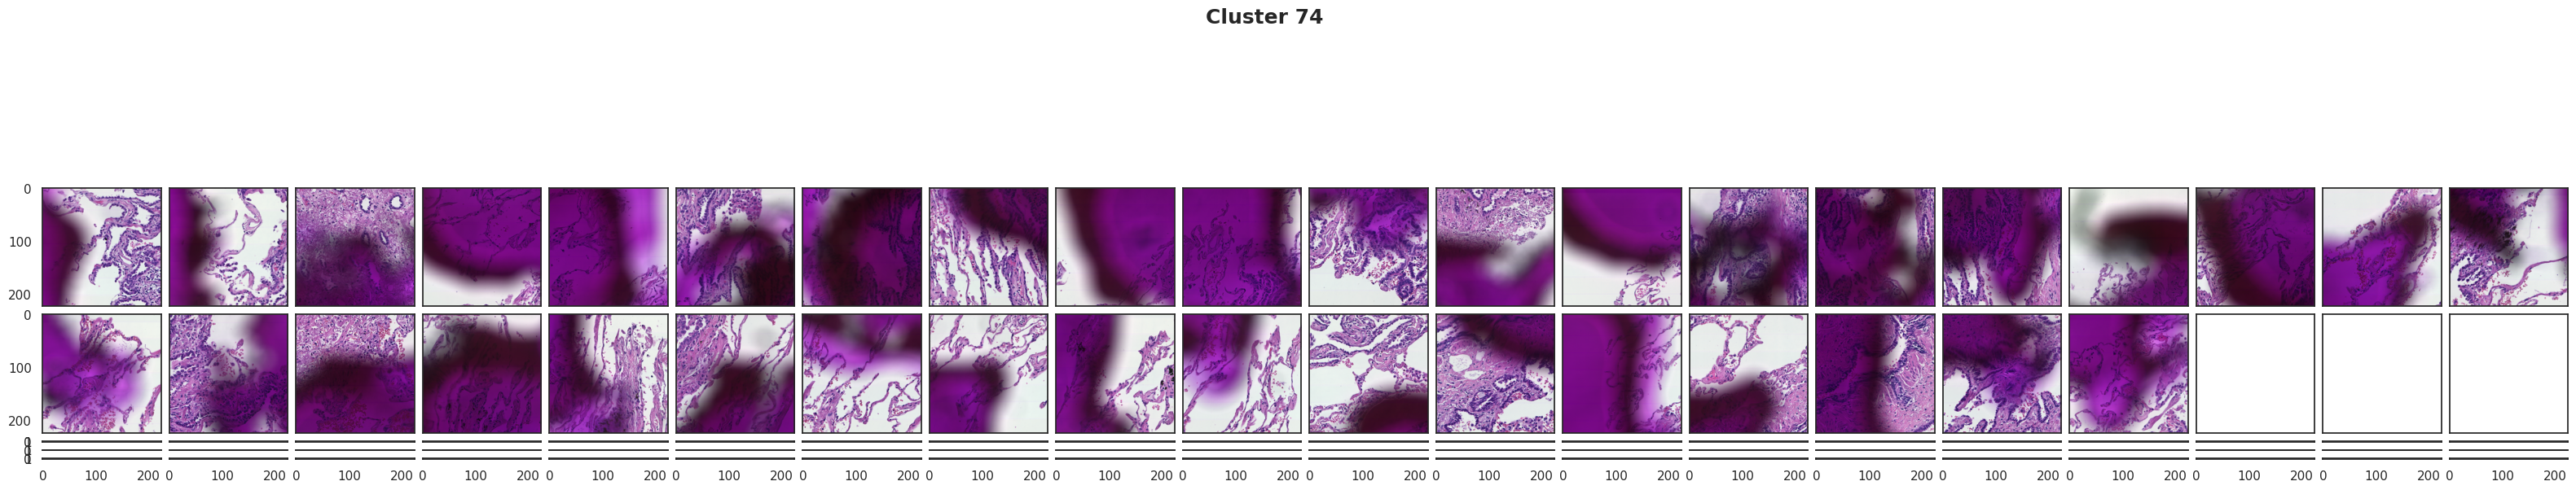




Cluster 79 Number of samples: 0
Cluster 80 Number of samples: 0
Cluster 85 Number of samples: 0
Cluster 92 Number of samples: 8
Cluster 94 Number of samples: 2
Cluster 100 Number of samples: 1
Cluster 102 Number of samples: 0
Cluster 105 Number of samples: 0
Cluster 107 Number of samples: 0


In [21]:
# Optionally, you can review the tiles within the clusters marked for removal
def cluster_set_images(frame, images, cluster_id, groupby, batches=1):
    cluster_frame = frame[frame[groupby].astype(int)==cluster_id]
    combined      = cluster_frame.index.tolist()
    random.shuffle(combined)
    combined_plot = sorted(combined[:100*batches])

    for batch in range(batches):
        images_cluster = list()
        for index in combined_plot[100*batch:100*(batch+1)]:
            images_cluster.append(images[int(index)]/255.)

        sns.set_theme(style='white')
        fig = plt.figure(figsize=(40, 8))
        fig.suptitle('Cluster %s' % (cluster_id), fontsize=18, fontweight='bold')
        grid = ImageGrid(fig, 111, nrows_ncols=(5, 20), axes_pad=0.1,)

        for ax, im in zip(grid, images_cluster):
            ax.imshow(im)

        plt.show()
        sns.set_theme(style='darkgrid')

for cluster_id in clusters_to_remove:
    print('Cluster', cluster_id, 'Number of samples:', data_clusters[data_clusters[groupby].astype(int)==cluster_id].shape[0])
    if data_clusters[data_clusters[groupby].astype(int)==cluster_id].shape[0]<20: continue
    cluster_set_images(data_clusters, data.training.images, cluster_id, groupby, batches=1)
    print()
    print()
    print()

In [45]:
indexes_remove_path = 'utilities/files/indexes_to_remove'
data_remove_path    = os.path.join(dbs_path, indexes_remove_path, dataset)

if not os.path.isdir(data_remove_path):
    os.makedirs(data_remove_path)

In [46]:
indexes_set = data_clusters.index.astype(int).values.tolist() 

set_name = data.training.hdf5_path.split('/hdf5_')[1].replace('.h5', '')
pickle_path = os.path.join(data_remove_path, '%s.pkl' % set_name)
if len(indexes_set) > 0:
    store_data(indexes_set, pickle_path)